# Previous Trial Effects by Reaction Time

This notebook investigates whether **previous trial effects** differ based on **reaction time**.

**Hypothesis**: 
- **Fast decisions** may be more automatic/habitual, relying more on previous trial outcomes
- **Slow decisions** may be more deliberative, relying more on actual trial parameters (EV, ambiguity)

**Analysis**:
1. Split data by reaction time (fast vs slow)
2. Compare transition probabilities in each group
3. Compare model accuracy with/without sequential features in each group

In [17]:
# ============================================================================
# CONFIGURATION
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
RT_VARIABLE = 'reaction_time'  # Options: 'reaction_time', 'decision_time'
# ============================================================================

import sys
sys.path.append('../../..')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

from src.utils.io import load_features, save_results
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*70}")
print(f"PREVIOUS TRIAL EFFECTS BY REACTION TIME: {TIMEFRAME}-DECISION")
print(f"{'='*70}\n")


PREVIOUS TRIAL EFFECTS BY REACTION TIME: PRE-DECISION



## 1. Load Data and Add Sequential Features

In [18]:
# Load pre-extracted features
features_path = f'../../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df'].copy()
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nReaction time distribution (ms):")
print(merged_df[RT_VARIABLE].describe())

Loaded 12511 trials from 97 subjects

Reaction time distribution (ms):
count    12511.000000
mean         1.591410
std          0.732791
min          0.144252
25%          1.032831
50%          1.410741
75%          1.976653
max          4.575594
Name: reaction_time, dtype: float64


In [19]:
# Extract trial number and sort
def extract_trial_number(trial_id):
    parts = trial_id.split('_')
    return int(parts[0])

merged_df['trial_number'] = merged_df['trial_id'].apply(extract_trial_number)
merged_df = merged_df.sort_values(['subject_id', 'trial_number']).reset_index(drop=True)

# Add sequential features
def add_sequential_features(df, group_col='subject_id'):
    df['prev_outcome'] = df.groupby(group_col)['outcome'].shift(1)
    df['prev_outcome_2'] = df.groupby(group_col)['outcome'].shift(2)
    df['running_invest_rate'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['recent_invest_rate_5'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
    )
    df['trial_position'] = df.groupby(group_col)['trial_number'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    
    def count_consecutive(series):
        result = [0]
        count = 0
        for i in range(1, len(series)):
            if series.iloc[i-1] == series.iloc[i-2] if i > 1 else True:
                count += 1
            else:
                count = 0
            result.append(count)
        return pd.Series(result, index=series.index)
    
    df['consecutive_same'] = df.groupby(group_col)['outcome'].transform(count_consecutive)
    return df

merged_df = add_sequential_features(merged_df)
sequential_cols = ['prev_outcome', 'prev_outcome_2', 'running_invest_rate', 
                   'recent_invest_rate_5', 'trial_position', 'consecutive_same']

# Filter to valid trials (with previous outcome)
df_valid = merged_df[merged_df['prev_outcome'].notna()].copy()
print(f"Trials with valid sequential features: {len(df_valid)}")

Trials with valid sequential features: 12414


In [20]:
# Split by RT using median split
# Following the same method as notebooks/fusion_models/reaction_time_group_late_fusion.ipynb
rt_median = df_valid[RT_VARIABLE].median()
df_valid['rt_group'] = df_valid[RT_VARIABLE].apply(lambda x: 'Fast' if x <= rt_median else 'Slow')

# Convert to categorical with proper ordering
df_valid['rt_group'] = pd.Categorical(df_valid['rt_group'], 
                                       categories=['Fast', 'Slow'], 
                                       ordered=True)

print(f"Median {RT_VARIABLE}: {rt_median:.2f}s")
print(f"\nTrials by RT group:")
print(df_valid['rt_group'].value_counts().sort_index())

print(f"\n{RT_VARIABLE} range by group:")
for group in ['Fast', 'Slow']:
    group_data = df_valid[df_valid['rt_group'] == group]
    print(f"  {group}: {group_data[RT_VARIABLE].min():.2f}s - {group_data[RT_VARIABLE].max():.2f}s (mean: {group_data[RT_VARIABLE].mean():.2f}s)")

Median reaction_time: 1.41s

Trials by RT group:
rt_group
Fast    6207
Slow    6207
Name: count, dtype: int64

reaction_time range by group:
  Fast: 0.14s - 1.41s (mean: 1.03s)
  Slow: 1.41s - 4.58s (mean: 2.15s)


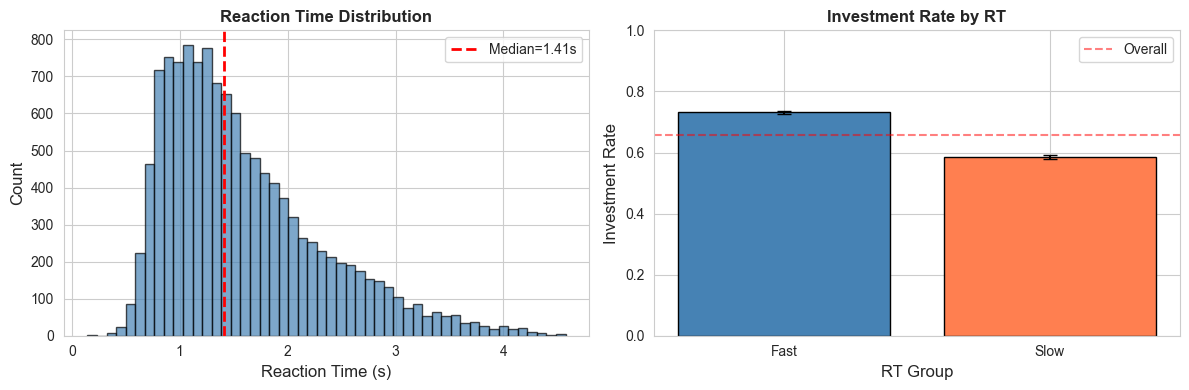

In [21]:
# Visualize RT distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram with median line
ax1 = axes[0]
ax1.hist(df_valid[RT_VARIABLE], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=rt_median, color='red', linestyle='--', linewidth=2, label=f'Median={rt_median:.2f}s')
ax1.set_xlabel(f'{RT_VARIABLE.replace("_", " ").title()} (s)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'{RT_VARIABLE.replace("_", " ").title()} Distribution', fontsize=12, fontweight='bold')
ax1.legend()

# Investment rate by RT group
ax2 = axes[1]
invest_by_group = df_valid.groupby('rt_group')['outcome'].agg(['mean', 'sem'])
colors = ['steelblue', 'coral']
bars = ax2.bar(invest_by_group.index, invest_by_group['mean'], 
               yerr=invest_by_group['sem'], capsize=5, color=colors, edgecolor='black')
ax2.axhline(y=df_valid['outcome'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall')
ax2.set_ylabel('Investment Rate', fontsize=12)
ax2.set_xlabel('RT Group', fontsize=12)
ax2.set_title('Investment Rate by RT', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Transition Probabilities by RT

In [22]:
print("="*70)
print("TRANSITION PROBABILITIES BY REACTION TIME")
print("="*70)

transition_results = []

for group in df_valid['rt_group'].cat.categories:
    df_group = df_valid[df_valid['rt_group'] == group]
    
    prev_invest = df_group[df_group['prev_outcome'] == 1]
    prev_keep = df_group[df_group['prev_outcome'] == 0]
    
    p_invest_after_invest = prev_invest['outcome'].mean()
    p_invest_after_keep = prev_keep['outcome'].mean()
    
    # Chi-square test
    contingency = pd.crosstab(df_group['prev_outcome'], df_group['outcome'])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    transition_results.append({
        'RT_Group': group,
        'N': len(df_group),
        'Mean_RT': df_group[RT_VARIABLE].mean(),
        'P(I|I)': p_invest_after_invest,
        'P(I|K)': p_invest_after_keep,
        'Difference': p_invest_after_invest - p_invest_after_keep,
        'Chi2': chi2,
        'p-value': p_value
    })
    
    print(f"\n{group} RT (n={len(df_group)}, mean={df_group[RT_VARIABLE].mean():.0f}ms):")
    print(f"  P(INVEST | prev=INVEST) = {p_invest_after_invest:.3f}")
    print(f"  P(INVEST | prev=KEEP)   = {p_invest_after_keep:.3f}")
    print(f"  Difference: {p_invest_after_invest - p_invest_after_keep:.3f}")
    print(f"  Chi-square: χ²={chi2:.2f}, p={p_value:.2e}")

transition_df = pd.DataFrame(transition_results)
print("\n" + transition_df.to_string(index=False))

TRANSITION PROBABILITIES BY REACTION TIME

Fast RT (n=6207, mean=1ms):
  P(INVEST | prev=INVEST) = 0.799
  P(INVEST | prev=KEEP)   = 0.564
  Difference: 0.235
  Chi-square: χ²=354.36, p=4.76e-79

Slow RT (n=6207, mean=2ms):
  P(INVEST | prev=INVEST) = 0.638
  P(INVEST | prev=KEEP)   = 0.507
  Difference: 0.131
  Chi-square: χ²=103.93, p=2.10e-24

RT_Group    N  Mean_RT   P(I|I)   P(I|K)  Difference       Chi2      p-value
    Fast 6207 1.029085 0.798649 0.563667    0.234981 354.359008 4.763436e-79
    Slow 6207 2.147343 0.638042 0.507493    0.130549 103.925235 2.100964e-24


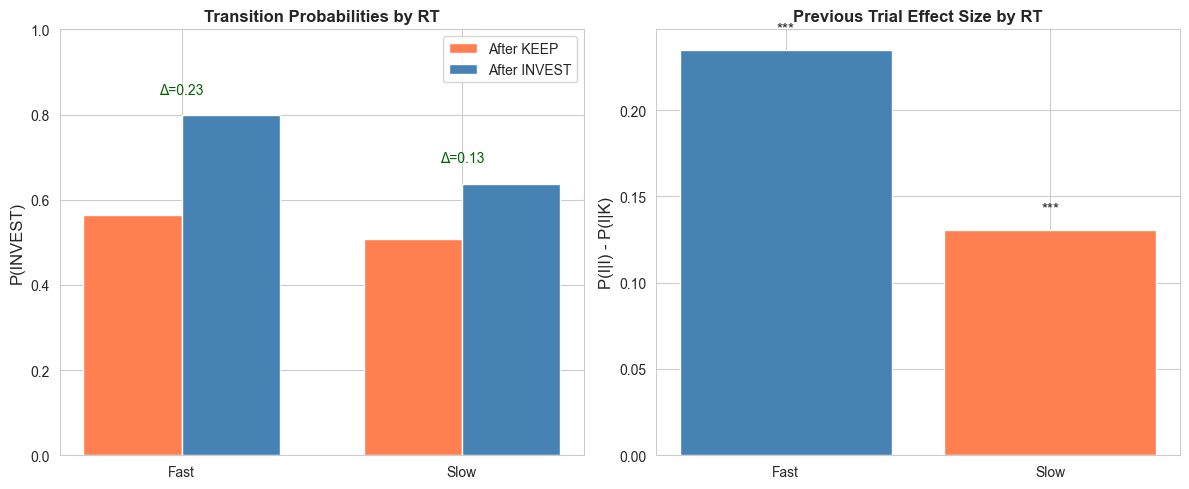

In [23]:
# Visualize transition probabilities by RT
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Transition probabilities comparison
ax1 = axes[0]
x = np.arange(len(transition_df))
width = 0.35

bars1 = ax1.bar(x - width/2, transition_df['P(I|K)'], width, label='After KEEP', color='coral')
bars2 = ax1.bar(x + width/2, transition_df['P(I|I)'], width, label='After INVEST', color='steelblue')

ax1.set_ylabel('P(INVEST)', fontsize=12)
ax1.set_title('Transition Probabilities by RT', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(transition_df['RT_Group'])
ax1.legend()
ax1.set_ylim(0, 1)

# Add difference annotations
for i, (idx, row) in enumerate(transition_df.iterrows()):
    ax1.annotate(f"Δ={row['Difference']:.2f}", 
                 xy=(i, max(row['P(I|I)'], row['P(I|K)']) + 0.05),
                 ha='center', fontsize=10, color='darkgreen')

# 2. Effect size (difference) comparison
ax2 = axes[1]
colors = ['steelblue', 'coral'] if len(transition_df) == 2 else plt.cm.viridis(np.linspace(0.2, 0.8, len(transition_df)))
bars = ax2.bar(transition_df['RT_Group'], transition_df['Difference'], color=colors)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('P(I|I) - P(I|K)', fontsize=12)
ax2.set_title('Previous Trial Effect Size by RT', fontsize=12, fontweight='bold')

# Add significance stars
for i, (idx, row) in enumerate(transition_df.iterrows()):
    sig = '***' if row['p-value'] < 0.001 else '**' if row['p-value'] < 0.01 else '*' if row['p-value'] < 0.05 else 'ns'
    ax2.text(i, row['Difference'] + 0.01, sig, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Model Comparison by RT

In [24]:
def evaluate_model(X, y, subjects, name, verbose=False):
    """Evaluate model using LOSO CV."""
    logo = LeaveOneGroupOut()
    accs = []
    
    unique_subjects = np.unique(subjects)
    if len(unique_subjects) < 3:
        from sklearn.model_selection import cross_val_score
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        return {'accuracy': np.mean(scores), 'accuracy_sem': stats.sem(scores)}
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
    
    return {'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs)}

def weighted_late_fusion(X_modalities, y, subjects, modality_names=None):
    """Weighted late fusion with optional weight tracking."""
    logo = LeaveOneGroupOut()
    accs = []
    all_weights = []
    
    unique_subjects = np.unique(subjects)
    if len(unique_subjects) < 3:
        return {'accuracy': 0.5, 'accuracy_sem': 0.0, 'weights': {}}
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        n_inner = min(5, len(np.unique(train_subjects)) - 1)
        if n_inner < 2:
            n_inner = 2
        
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        gkf_inner = GroupKFold(n_splits=n_inner)
        
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        test_probs = []
        for X in X_modalities:
            model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
            model.fit(X[train_idx], y_train)
            test_probs.append(model.predict_proba(X[test_idx])[:, 1])
        test_probs = np.column_stack(test_probs)
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        y_pred = meta.predict(test_probs)
        accs.append(accuracy_score(y_test, y_pred))
        all_weights.append(meta.coef_[0])
    
    # Calculate normalized weights
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    weights_dict = {}
    if modality_names:
        weights_dict = dict(zip(modality_names, norm_weights))
    
    return {'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs), 'weights': weights_dict}

In [25]:
print("\n" + "="*70)
print("MODEL COMPARISON BY REACTION TIME")
print("="*70)

model_results = []
weights_by_group = {}  # Store weights for visualization

modality_names_baseline = ['Physio', 'Behavior', 'Gaze']
modality_names_with_seq = ['Physio', 'Behavior', 'Gaze', 'Sequential']

for group in df_valid['rt_group'].cat.categories:
    print(f"\n--- {group} RT ---")
    df_group = df_valid[df_valid['rt_group'] == group].copy()
    df_group = df_group.reset_index(drop=True)
    
    # Prepare features (exclude RT from behavior since we're splitting by it)
    behavior_cols_no_rt = [c for c in behavior_cols if c != RT_VARIABLE]
    
    X_physio = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[physio_cols]))
    X_behavior = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[behavior_cols_no_rt]))
    X_gaze = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[gaze_cols])) if len(gaze_cols) > 0 else np.zeros((len(df_group), 1))
    X_sequential = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[sequential_cols]))
    
    y = df_group['outcome'].values
    subjects = df_group['subject_id'].values
    
    # Baseline: P+B+G
    results_baseline = weighted_late_fusion([X_physio, X_behavior, X_gaze], y, subjects, modality_names_baseline)
    print(f"  Baseline (P+B+G): {results_baseline['accuracy']:.3f}")
    print(f"    Weights: {results_baseline['weights']}")
    
    # With Sequential: P+B+G+S
    results_with_seq = weighted_late_fusion([X_physio, X_behavior, X_gaze, X_sequential], y, subjects, modality_names_with_seq)
    print(f"  With Sequential: {results_with_seq['accuracy']:.3f}")
    print(f"    Weights: {results_with_seq['weights']}")
    
    # Sequential only
    results_seq = evaluate_model(X_sequential, y, subjects, "Sequential")
    print(f"  Sequential Only: {results_seq['accuracy']:.3f}")
    
    improvement = results_with_seq['accuracy'] - results_baseline['accuracy']
    print(f"  Improvement: {improvement:+.3f}")
    
    # Store weights for plotting
    weights_by_group[group] = {
        'baseline': results_baseline,
        'with_seq': results_with_seq
    }
    
    model_results.append({
        'RT_Group': group,
        'N': len(df_group),
        'Mean_RT': df_group[RT_VARIABLE].mean(),
        'Baseline': results_baseline['accuracy'],
        'Baseline_SEM': results_baseline['accuracy_sem'],
        'With_Sequential': results_with_seq['accuracy'],
        'With_Seq_SEM': results_with_seq['accuracy_sem'],
        'Sequential_Only': results_seq['accuracy'],
        'Improvement': improvement
    })

model_df = pd.DataFrame(model_results)
print("\n" + model_df.to_string(index=False))


MODEL COMPARISON BY REACTION TIME

--- Fast RT ---
  Baseline (P+B+G): 0.713
    Weights: {'Physio': np.float64(0.07215747786934767), 'Behavior': np.float64(0.9257209192145822), 'Gaze': np.float64(0.002121602916070142)}
  With Sequential: 0.806
    Weights: {'Physio': np.float64(0.008064629053133482), 'Behavior': np.float64(0.3980987417206295), 'Gaze': np.float64(0.001526232135122647), 'Sequential': np.float64(0.5923103970911143)}
  Sequential Only: 0.654
  Improvement: +0.094

--- Slow RT ---
  Baseline (P+B+G): 0.631
    Weights: {'Physio': np.float64(0.054947817002649384), 'Behavior': np.float64(0.9208624229733355), 'Gaze': np.float64(0.02418976002401507)}
  With Sequential: 0.649
    Weights: {'Physio': np.float64(0.01995953437191299), 'Behavior': np.float64(0.46310648973006513), 'Gaze': np.float64(0.0077394347595159865), 'Sequential': np.float64(0.5091945411385058)}
  Sequential Only: 0.571
  Improvement: +0.018

RT_Group    N  Mean_RT  Baseline  Baseline_SEM  With_Sequential  Wi

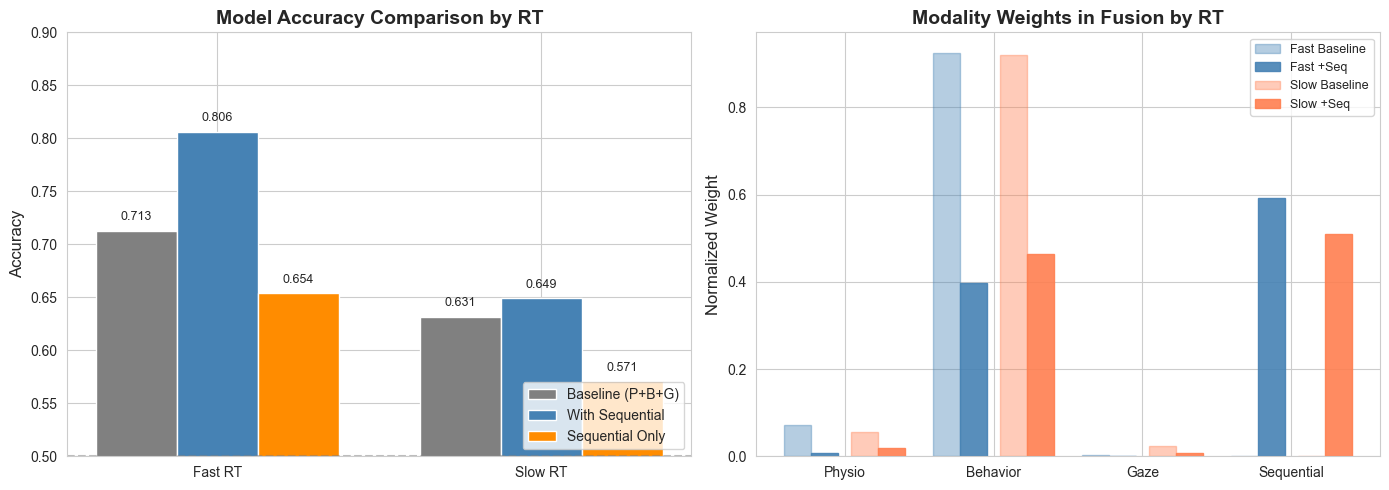

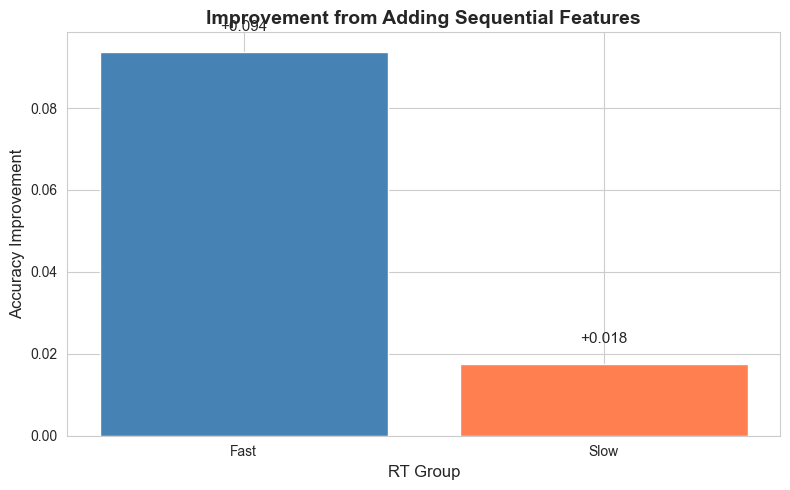

In [26]:
# Visualize model comparison (like in previous_trial_effects.ipynb)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

groups = list(df_valid['rt_group'].cat.categories)

# 1. Model accuracy comparison by RT group
ax1 = axes[0]
x = np.arange(len(groups))
width = 0.25

# Create comparison dataframe for each group
for i, group in enumerate(groups):
    row = model_df[model_df['RT_Group'] == group].iloc[0]
    bars1 = ax1.bar(i - width, row['Baseline'], width, 
                    label='Baseline (P+B+G)' if i == 0 else '', color='gray')
    bars2 = ax1.bar(i, row['With_Sequential'], width,
                    label='With Sequential' if i == 0 else '', color='steelblue')
    bars3 = ax1.bar(i + width, row['Sequential_Only'], width,
                    label='Sequential Only' if i == 0 else '', color='darkorange')
    
    # Add accuracy labels
    ax1.text(i - width, row['Baseline'] + 0.01, f"{row['Baseline']:.3f}", ha='center', fontsize=9)
    ax1.text(i, row['With_Sequential'] + 0.01, f"{row['With_Sequential']:.3f}", ha='center', fontsize=9)
    ax1.text(i + width, row['Sequential_Only'] + 0.01, f"{row['Sequential_Only']:.3f}", ha='center', fontsize=9)

ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison by RT', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{g} RT' for g in groups])
ax1.legend(loc='lower right')
ax1.set_ylim(0.5, 0.9)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# 2. Modality weights comparison (baseline vs with sequential) for each RT group
ax2 = axes[1]
x = np.arange(len(modality_names_with_seq))
width = 0.18
colors_groups = ['steelblue', 'coral']

for i, group in enumerate(groups):
    baseline_weights = [weights_by_group[group]['baseline']['weights'].get(n, 0) for n in modality_names_with_seq]
    with_seq_weights = [weights_by_group[group]['with_seq']['weights'].get(n, 0) for n in modality_names_with_seq]
    
    offset = (i - 0.5) * width * 2.5
    ax2.bar(x + offset - width/2, baseline_weights, width, 
            label=f'{group} Baseline' if i == 0 else f'{group} Baseline', 
            color=colors_groups[i], alpha=0.4, edgecolor=colors_groups[i])
    ax2.bar(x + offset + width/2, with_seq_weights, width,
            label=f'{group} +Seq' if i == 0 else f'{group} +Seq',
            color=colors_groups[i], alpha=0.9, edgecolor=colors_groups[i])

ax2.set_ylabel('Normalized Weight', fontsize=12)
ax2.set_title('Modality Weights in Fusion by RT', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(modality_names_with_seq)
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Additional: Improvement comparison
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['steelblue', 'coral']
bars = ax.bar(model_df['RT_Group'], model_df['Improvement'], color=colors)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Accuracy Improvement', fontsize=12)
ax.set_xlabel('RT Group', fontsize=12)
ax.set_title('Improvement from Adding Sequential Features', fontsize=14, fontweight='bold')

for i, (idx, row) in enumerate(model_df.iterrows()):
    ax.text(i, row['Improvement'] + 0.005, f"{row['Improvement']:+.3f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## 5. Feature Importance by RT

In [27]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE BY REACTION TIME (ALL MODALITIES)")
print("="*70)

# Compare feature importance across RT groups for ALL modalities
importance_by_group = {}
all_importance_dfs = {}

for group in df_valid['rt_group'].cat.categories:
    df_group = df_valid[df_valid['rt_group'] == group].copy()
    
    behavior_cols_no_rt = [c for c in behavior_cols if c != RT_VARIABLE]
    
    # Combine ALL modalities
    X_all = np.hstack([
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[physio_cols])),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[behavior_cols_no_rt])),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[gaze_cols])) if len(gaze_cols) > 0 else np.zeros((len(df_group), 1)),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[sequential_cols]))
    ])
    all_cols = physio_cols + behavior_cols_no_rt + (gaze_cols if len(gaze_cols) > 0 else ['gaze_placeholder']) + sequential_cols
    modality_labels = (['Physiology'] * len(physio_cols) + 
                       ['Behavior'] * len(behavior_cols_no_rt) + 
                       ['Gaze'] * len(gaze_cols if len(gaze_cols) > 0 else ['gaze_placeholder']) + 
                       ['Sequential'] * len(sequential_cols))
    
    y_group = df_group['outcome'].values
    
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X_all, y_group)
    
    importance_by_group[group] = dict(zip(all_cols, np.abs(model.coef_[0])))
    
    # Create importance dataframe for this group
    all_importance_dfs[group] = pd.DataFrame({
        'Feature': all_cols,
        'Coefficient': np.abs(model.coef_[0]),
        'Type': modality_labels
    }).sort_values('Coefficient', ascending=False)

# Show top 15 features for each group
for group in df_valid['rt_group'].cat.categories:
    print(f"\n--- {group} RT: Top 15 Features ---")
    print(all_importance_dfs[group].head(15).to_string(index=False))

# Total importance by modality for each group
print("\n--- Total Importance by Modality ---")
for group in df_valid['rt_group'].cat.categories:
    modality_importance = all_importance_dfs[group].groupby('Type')['Coefficient'].sum().sort_values(ascending=False)
    print(f"\n{group} RT:")
    print(modality_importance.to_string())


FEATURE IMPORTANCE BY REACTION TIME (ALL MODALITIES)

--- Fast RT: Top 15 Features ---
                   Feature  Coefficient       Type
          consecutive_same     1.282950 Sequential
       running_invest_rate     1.171991 Sequential
    gaze_acceleration_mean     1.103140       Gaze
                 ambiguity     0.974402   Behavior
        gaze_velocity_mean     0.801328       Gaze
         gaze_velocity_std     0.788504       Gaze
             saccade_ratio     0.676405       Gaze
            fixation_ratio     0.437987       Gaze
          gaze_path_length     0.396103       Gaze
             saccade_count     0.307480       Gaze
pupil_acceleration_std_pre     0.297709 Physiology
           invest_variance     0.281185   Behavior
           pupil_slope_pre     0.212312 Physiology
              risk_premium     0.208955   Behavior
         gaze_dispersion_y     0.199730       Gaze

--- Slow RT: Top 15 Features ---
                        Feature  Coefficient       Type
      

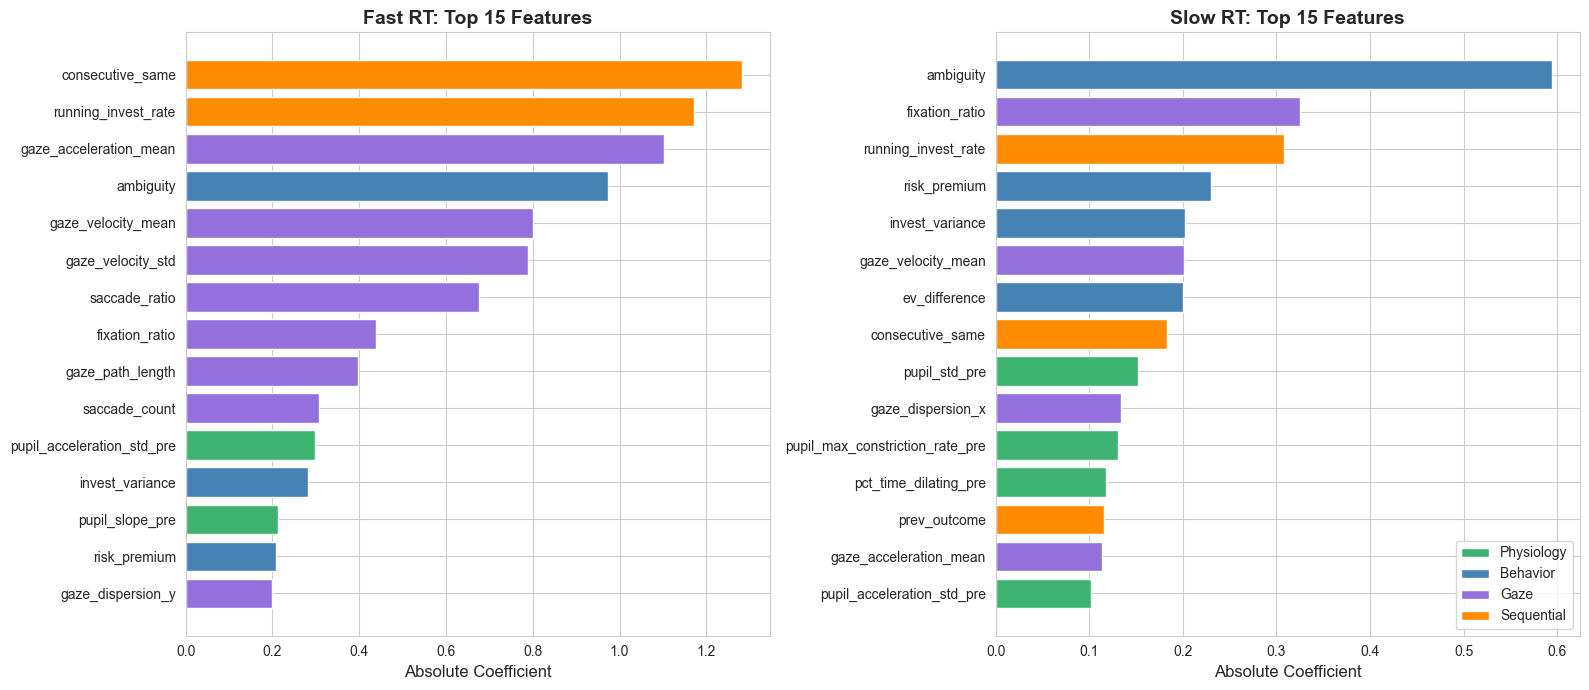

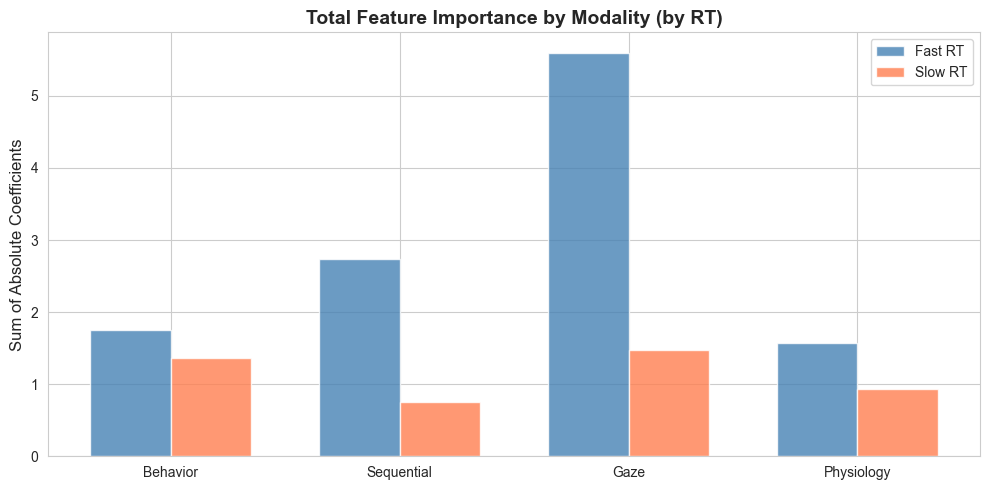

In [28]:
# Visualize feature importance (Top 15 features for each RT group with all modalities)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Color mapping for modalities
color_map = {
    'Physiology': 'mediumseagreen',
    'Behavior': 'steelblue', 
    'Gaze': 'mediumpurple',
    'Sequential': 'darkorange'
}

groups = list(df_valid['rt_group'].cat.categories)

for idx, group in enumerate(groups):
    ax = axes[idx]
    top15 = all_importance_dfs[group].head(15)
    colors = [color_map[t] for t in top15['Type']]
    bars = ax.barh(top15['Feature'], top15['Coefficient'], color=colors)
    
    ax.set_xlabel('Absolute Coefficient', fontsize=12)
    ax.set_title(f'{group} RT: Top 15 Features', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

# Add legend to last subplot
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=m) for m, c in color_map.items()]
axes[-1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Total importance by modality comparison
fig, ax = plt.subplots(figsize=(10, 5))

modality_order = ['Behavior', 'Sequential', 'Gaze', 'Physiology']
x = np.arange(len(modality_order))
width = 0.35

for i, group in enumerate(groups):
    modality_importance = all_importance_dfs[group].groupby('Type')['Coefficient'].sum()
    values = [modality_importance.get(m, 0) for m in modality_order]
    offset = (i - len(groups)/2 + 0.5) * width
    color = 'steelblue' if i == 0 else 'coral'
    ax.bar(x + offset, values, width, label=f'{group} RT', color=color, alpha=0.8)

ax.set_ylabel('Sum of Absolute Coefficients', fontsize=12)
ax.set_title('Total Feature Importance by Modality (by RT)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modality_order)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Additional Analysis: RT and Previous Outcome Interaction

In [29]:
# Does RT differ based on previous outcome?
print("\n" + "="*70)
print("REACTION TIME BY PREVIOUS OUTCOME")
print("="*70)

rt_by_prev = df_valid.groupby('prev_outcome')[RT_VARIABLE].agg(['mean', 'std', 'count'])
print(f"\n{RT_VARIABLE} by previous outcome:")
print(rt_by_prev.round(1))

# T-test
rt_after_invest = df_valid[df_valid['prev_outcome'] == 1][RT_VARIABLE]
rt_after_keep = df_valid[df_valid['prev_outcome'] == 0][RT_VARIABLE]
t_stat, p_val = stats.ttest_ind(rt_after_invest, rt_after_keep)
print(f"\nT-test (RT after INVEST vs KEEP): t={t_stat:.2f}, p={p_val:.4f}")

# Effect size
cohens_d = (rt_after_invest.mean() - rt_after_keep.mean()) / np.sqrt(
    ((len(rt_after_invest)-1)*rt_after_invest.std()**2 + (len(rt_after_keep)-1)*rt_after_keep.std()**2) / 
    (len(rt_after_invest) + len(rt_after_keep) - 2)
)
print(f"Cohen's d: {cohens_d:.3f}")


REACTION TIME BY PREVIOUS OUTCOME

reaction_time by previous outcome:
              mean  std  count
prev_outcome                  
0.0            1.7  0.7   4236
1.0            1.5  0.7   8178

T-test (RT after INVEST vs KEEP): t=-12.81, p=0.0000
Cohen's d: -0.242


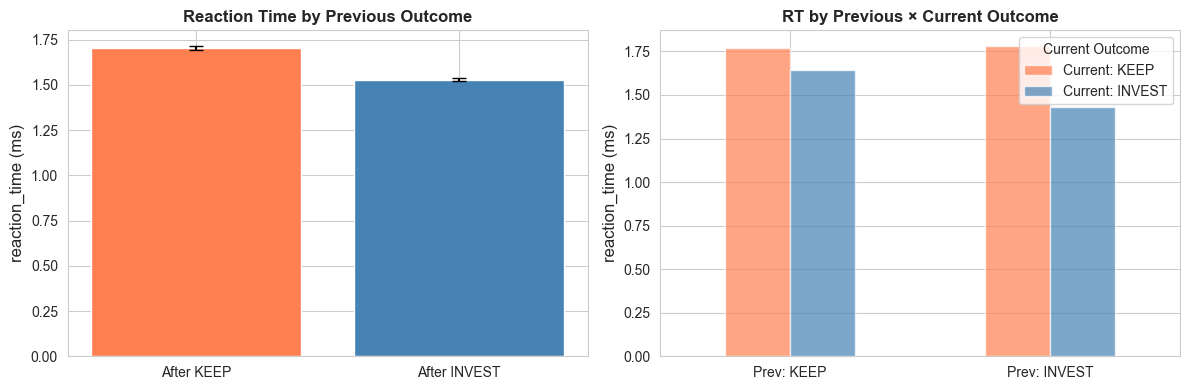

In [30]:
# Visualize RT by previous outcome and current outcome
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. RT by previous outcome
ax1 = axes[0]
rt_means = df_valid.groupby('prev_outcome')[RT_VARIABLE].mean()
rt_sems = df_valid.groupby('prev_outcome')[RT_VARIABLE].sem()
labels = ['After KEEP', 'After INVEST']
bars = ax1.bar(labels, rt_means.values, yerr=rt_sems.values, capsize=5, color=['coral', 'steelblue'])
ax1.set_ylabel(f'{RT_VARIABLE} (ms)', fontsize=12)
ax1.set_title('Reaction Time by Previous Outcome', fontsize=12, fontweight='bold')

# 2. RT by previous and current outcome (2x2)
ax2 = axes[1]
rt_2x2 = df_valid.groupby(['prev_outcome', 'outcome'])[RT_VARIABLE].mean().unstack()
rt_2x2.columns = ['Current: KEEP', 'Current: INVEST']
rt_2x2.index = ['Prev: KEEP', 'Prev: INVEST']
rt_2x2.plot(kind='bar', ax=ax2, color=['coral', 'steelblue'], alpha=0.7)
ax2.set_ylabel(f'{RT_VARIABLE} (ms)', fontsize=12)
ax2.set_title('RT by Previous × Current Outcome', fontsize=12, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(title='Current Outcome')

plt.tight_layout()
plt.show()

## 7. Save Results

In [31]:
import os

output_dir = f'../../../data/results/previous_trial_effects_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

save_results(transition_df, f'{output_dir}/transitions_by_rt_{TIMEFRAME}.csv')
save_results(model_df, f'{output_dir}/models_by_rt_{TIMEFRAME}.csv')

# Save feature importance by RT group
for group in df_valid['rt_group'].cat.categories:
    save_results(all_importance_dfs[group], f'{output_dir}/feature_importance_{group}_rt_{TIMEFRAME}.csv')

print(f"\n✓ Results saved to: {output_dir}/")

✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/transitions_by_rt_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/models_by_rt_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/feature_importance_Fast_rt_PRE.csv
✓ Saved results to: ../../../data/results/previous_trial_effects_PRE/feature_importance_Slow_rt_PRE.csv

✓ Results saved to: ../../../data/results/previous_trial_effects_PRE/


## 8. Summary

In [32]:
print("\n" + "="*70)
print(f"SUMMARY: PREVIOUS TRIAL EFFECTS BY REACTION TIME ({TIMEFRAME})")
print("="*70)

print("\n1. TRANSITION PROBABILITY DIFFERENCES:")
for _, row in transition_df.iterrows():
    print(f"   {row['RT_Group']} RT ({row['Mean_RT']:.0f}ms): Δ = {row['Difference']:.3f} (p={row['p-value']:.2e})")

# Compare effect sizes
if len(transition_df) == 2:
    fast_effect = transition_df[transition_df['RT_Group'] == 'Fast']['Difference'].values[0]
    slow_effect = transition_df[transition_df['RT_Group'] == 'Slow']['Difference'].values[0]
    print(f"\n   → Previous trial effect is {'STRONGER' if fast_effect > slow_effect else 'WEAKER'} in fast decisions")
    print(f"   → Difference: {fast_effect - slow_effect:+.3f}")

print("\n2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:")
for _, row in model_df.iterrows():
    print(f"   {row['RT_Group']} RT: {row['Improvement']:+.3f} ({row['Baseline']:.3f} → {row['With_Sequential']:.3f})")

print("\n3. INTERPRETATION:")
if len(model_df) == 2:
    fast_imp = model_df[model_df['RT_Group'] == 'Fast']['Improvement'].values[0]
    slow_imp = model_df[model_df['RT_Group'] == 'Slow']['Improvement'].values[0]
    
    if fast_imp > slow_imp + 0.01:
        print("   ✓ Sequential features help MORE in fast decisions")
        print("   ✓ Fast decisions are more habitual/automatic, relying on past behavior")
    elif slow_imp > fast_imp + 0.01:
        print("   ✓ Sequential features help MORE in slow decisions")
        print("   ✓ Even deliberative decisions are influenced by past behavior")
    else:
        print("   ~ Sequential features help SIMILARLY across RT groups")
        print("   ~ Previous trial effects are consistent regardless of decision speed")

print("\n" + "="*70)


SUMMARY: PREVIOUS TRIAL EFFECTS BY REACTION TIME (PRE)

1. TRANSITION PROBABILITY DIFFERENCES:
   Fast RT (1ms): Δ = 0.235 (p=4.76e-79)
   Slow RT (2ms): Δ = 0.131 (p=2.10e-24)

   → Previous trial effect is STRONGER in fast decisions
   → Difference: +0.104

2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:
   Fast RT: +0.094 (0.713 → 0.806)
   Slow RT: +0.018 (0.631 → 0.649)

3. INTERPRETATION:
   ✓ Sequential features help MORE in fast decisions
   ✓ Fast decisions are more habitual/automatic, relying on past behavior

